# Práctica 1

In [1]:
import torch
from google.colab import drive

drive.mount('/content/gdrive')

route = '/content/gdrive/MyDrive/GIA/VCA/P1'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here are our files:")
!ls -lasth

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current directory:
/content

We now change the directory to '/content/gdrive/MyDrive/GIA/VCA/P1'
/content/gdrive/MyDrive/GIA/VCA/P1
/content/gdrive/MyDrive/GIA/VCA/P1

And here are our files:
total 39M
4.9M -rw------- 1 root root 4.9M Apr 10 14:58 npt_no_DA_ship.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:17 pt_no_DA_docked.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:17 npt_DA_docked.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:17 npt_no_DA_docked.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:17 pt_DA_docked.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:17 pt_DA_ship.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:17 pt_no_DA_ship.pth
4.9M -rw------- 1 root root 4.9M Apr 10 08:17 npt_DA_ship.pth
4.0K drwx------ 3 root root 4.0K Mar 27 10:29 ship_dataset


Importamos las bibliotecas necesarias para realizar la práctica.

In [2]:
import os, glob, time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torchvision.transforms as transforms
from torchvision.io import read_image

from torchvision.models import squeezenet1_0
from torch import nn

from sklearn.model_selection import train_test_split

from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

seed = 42
batch_size = 64

## **Tarea 1**: Dataset class personalizada para la carga del dataset

### Clase `Dataset`
Hereda de `torch.utils.data.Dataset`. Esta clase se utiliza para cargar imágenes y sus etiquetas desde un directorio y un archivo CSV, respectivamente. También aplica transformaciones a las imágenes.

In [3]:
class Dataset(data.Dataset):
    def __init__(self, image_path, csv_path, transform=None):
        super().__init__()

        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])

        # leemos el csv y recortamos la cabecera
        lines = open(csv_path).readlines()[1:]
        self.img_files = list()
        self.labels = list()
        self.names = list()

        for line in lines:
            filename, label = line.split(";")
            img = read_image(os.path.join(image_path, filename))
            img = self.transform(img)
            self.img_files.append(img)
            self.labels.append(torch.tensor(int(label), dtype=torch.float32))
            self.names.append(os.path.splitext(os.path.basename(filename))[0])

        print("Imágenes en el dataset:", len(self.img_files))

    def __getitem__(self, index):
        image = self.img_files[index]
        label = self.labels[index]
        name = self.names[index]

        return image, label, name

    def __len__(self):
        return len(self.img_files)

    def plot_class_distribution(self):
        labels = np.array(self.labels)
        unique, counts = np.unique(labels, return_counts=True)

        plt.pie(counts, labels=unique, autopct='%1.1f%%')
        plt.show()


Definimos dos funciones: `tensor_to_image` para convertir un tensor en una imagen de NumPy y `show` para mostrar una imagen utilizando Matplotlib.

In [4]:
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, title=None):
    plt.imshow(image, cmap="grey")
    plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

### Creación del dataset

In [5]:
dir = "ship_dataset"
label_csv_filename = "ship.csv"

my_transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((144, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])

ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
print("Tamaño del dataset completo:", len(ship_dataset))

Imágenes en el dataset: 294
Tamaño del dataset completo: 294


1: Hay barco, 0: No hay barco


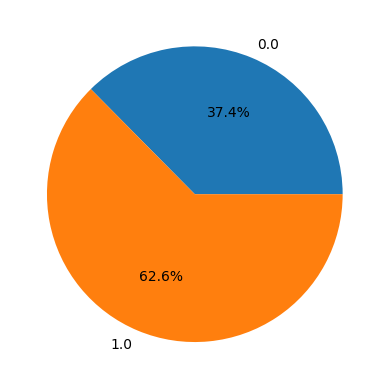

In [6]:
print("1: Hay barco, 0: No hay barco")
ship_dataset.plot_class_distribution()

Obtenemos una imagen, su etiqueta y su nombre del dataset en el índice 160. Después, mostramos la imagen utilizando la función `show`.

<ipython-input-4-165f0e13db72>:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  new_image[:,:] = tensor[0,:,:]


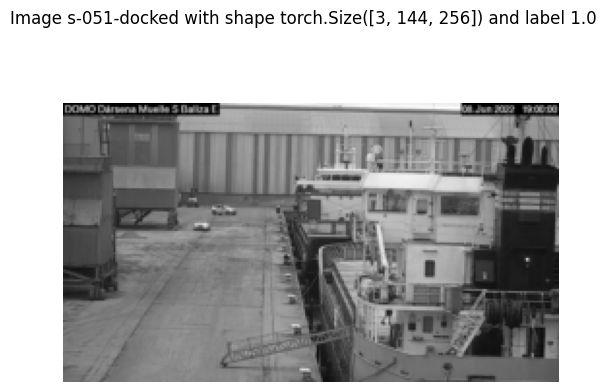

In [7]:
image, label, name = ship_dataset[160]
show(tensor_to_image(image), title=f"Image {name} with shape {image.shape} and label {label}")

### Creamos el primer modelo
Instanciamos el modelo `squeezenet1_0` de `torchvision.models`

In [8]:
model = squeezenet1_0(weights=None)
#print(model)

In [9]:
class Tail:
    def __init__(self):
        self.model = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size = 1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )


mymodel_no_da = nn.Sequential(
    model.features,
    Tail().model
)

image = image.unsqueeze(0)

output = mymodel_no_da(image)

print(image.shape)
print(output.shape)

torch.Size([1, 3, 144, 256])
torch.Size([1, 1])


## **Tarea 2**: Clasificación Ship/No-ship

### Separación en train, val y test

In [10]:
# 60-20-20
train_indices, test_indices = train_test_split(list(range(len(ship_dataset))), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

train_dataset = data.Subset(ship_dataset, train_indices)
val_dataset = data.Subset(ship_dataset, val_indices)
test_dataset = data.Subset(ship_dataset, test_indices)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Función de entrenamiento

In [11]:
from copy import deepcopy

def train_model(model, train_loader, val_loader, loss_fn, optim, device, model_name, epochs=20, ES_patience=3):
    print("Device:", device)
    model.to(device)

    train_losses, val_losses = list(), list()

    best_val_loss = np.inf
    best_model_weights = None
    best_epoch = -1

    patience = ES_patience
    epochs_without_improvement = 0

    for epoch in range(epochs):
        start_time = time.time()

        model.train() # modo train

        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        model.eval() # modo evaluación
        val_loss = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}],",
              f"train loss: {train_loss:.4f},",
              f"val loss: {val_loss:.4f},",
              f"time: {(time.time() - start_time):.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Parando el entrenamiento de forma temprana...")
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"El mejor modelo era el de la epoch {best_epoch+1} con una pérdida de validación de {best_val_loss:.4f}")
    torch.save(model.state_dict(), f"{model_name}.pth")

    return model, train_losses, val_losses

def plot_history(train, val):
    plt.clf()
    plt.plot(train, label="train")
    plt.plot(val, label="validation")
    plt.legend(loc="upper right")
    plt.show()

### Función de evaluación

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

def test_model(model, test_loader, threshold=0.5):
    print("Device:", device)
    model.eval()

    all_scores = list()
    all_predictions = list()
    all_targets = list()

    with torch.no_grad():
        for samples, targets, _ in test_loader:
            samples = samples.to(device)
            targets = targets.to(device)

            outputs = model(samples)
            predictions = (outputs > threshold).float()

            scores = outputs.cpu()
            predictions = predictions.cpu()
            targets = targets.cpu()

            all_scores.extend(scores)
            all_predictions.extend(predictions)
            all_targets.extend(targets)

    acc = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1score = f1_score(all_targets, all_predictions)

    print("Métricas:")
    print(f"test accuracy: {(acc*100):.2f} %")
    print(f"test precision: {(precision*100):.2f} %")
    print(f"test recall: {(recall*100):.2f} %")
    print(f"test f1: {(f1score*100):.2f} %")

    print("\nMatriz de confusión:")
    cm = confusion_matrix(all_targets, all_predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=np.array([0,1]))
    disp.plot(colorbar=False)
    plt.show()

    print("\nCurva ROC:")
    fpr, tpr, thresholds = roc_curve(all_targets, all_scores)
    roc_auc = auc(fpr, tpr)
    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot()
    plt.show()

    return acc, precision, recall, f1_score

### Modelo entrenado desde cero
#### Sin Data Augmentation

In [13]:
# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_no_da.parameters(), lr=0.001)

mymodel_no_da, train_losses, val_losses = train_model(mymodel_no_da,
                                                train_loader=train_loader,
                                                val_loader=val_loader,
                                                loss_fn=criterion,
                                                optim=optimizer,
                                                device=device,
                                                model_name="npt_no_DA_ship",
                                                epochs=99,
                                                ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.6464, val loss: 0.6732, time: 0.74s
Epoch [2/99], train loss: 0.6166, val loss: 0.7239, time: 0.37s
Epoch [3/99], train loss: 0.6235, val loss: 0.6513, time: 0.36s
Epoch [4/99], train loss: 0.5827, val loss: 0.6668, time: 0.36s
Epoch [5/99], train loss: 0.5658, val loss: 0.6188, time: 0.36s
Epoch [6/99], train loss: 0.5452, val loss: 0.6354, time: 0.36s
Epoch [7/99], train loss: 0.5271, val loss: 0.5987, time: 0.36s
Epoch [8/99], train loss: 0.4938, val loss: 0.6459, time: 0.36s
Epoch [9/99], train loss: 0.5917, val loss: 0.6906, time: 0.36s
Epoch [10/99], train loss: 0.4218, val loss: 0.5630, time: 0.36s
Epoch [11/99], train loss: 0.3853, val loss: 0.6254, time: 0.36s
Epoch [12/99], train loss: 0.4279, val loss: 0.5333, time: 0.36s
Epoch [13/99], train loss: 0.3027, val loss: 0.5050, time: 0.36s
Epoch [14/99], train loss: 0.2742, val loss: 0.5252, time: 0.36s
Epoch [15/99], train loss: 0.3966, val loss: 0.6141, time: 0.36s
Epoch [16/99], trai

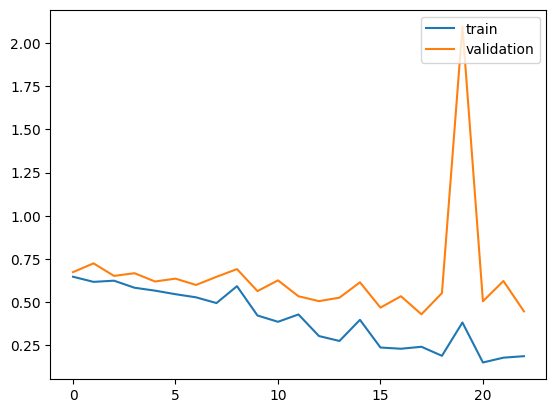

In [14]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [15]:
# Definimos las transformaciones con redimensionamiento y data augmentation
data_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creamos un nuevo dataset con el data augmentation
augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=data_augmentation_transforms)

aug_train_dataset = data.Subset(augmented_ship_dataset, train_indices)
aug_val_dataset = data.Subset(augmented_ship_dataset, val_indices)

aug_train_loader = data.DataLoader(aug_train_dataset, batch_size=batch_size)
aug_val_loader = data.DataLoader(aug_val_dataset, batch_size=batch_size)

Imágenes en el dataset: 294


In [16]:
# Definimos el modelo
mymodel_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_da.parameters(), lr=0.001)

mymodel_da, train_losses, val_losses = train_model(mymodel_da,
                                                    train_loader=aug_train_loader,
                                                    val_loader=aug_val_loader,
                                                    loss_fn=criterion,
                                                    optim=optimizer,
                                                    device=device,
                                                    model_name="npt_DA_ship",
                                                    epochs=99,
                                                    ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.6083, val loss: 0.6975, time: 0.44s
Epoch [2/99], train loss: 0.6920, val loss: 0.6852, time: 0.36s
Epoch [3/99], train loss: 0.6456, val loss: 0.6555, time: 0.36s
Epoch [4/99], train loss: 0.5982, val loss: 0.6438, time: 0.37s
Epoch [5/99], train loss: 0.5954, val loss: 0.6317, time: 0.36s
Epoch [6/99], train loss: 0.5822, val loss: 0.6069, time: 0.36s
Epoch [7/99], train loss: 0.5132, val loss: 0.5934, time: 0.37s
Epoch [8/99], train loss: 0.5264, val loss: 0.7566, time: 0.36s
Epoch [9/99], train loss: 0.6376, val loss: 0.5770, time: 0.36s
Epoch [10/99], train loss: 0.4653, val loss: 0.5731, time: 0.36s
Epoch [11/99], train loss: 0.5331, val loss: 0.5638, time: 0.36s
Epoch [12/99], train loss: 0.4489, val loss: 0.5600, time: 0.36s
Epoch [13/99], train loss: 0.6069, val loss: 0.6362, time: 0.37s
Epoch [14/99], train loss: 0.4401, val loss: 0.5666, time: 0.37s
Epoch [15/99], train loss: 0.3857, val loss: 0.5802, time: 0.37s
Epoch [16/99], trai

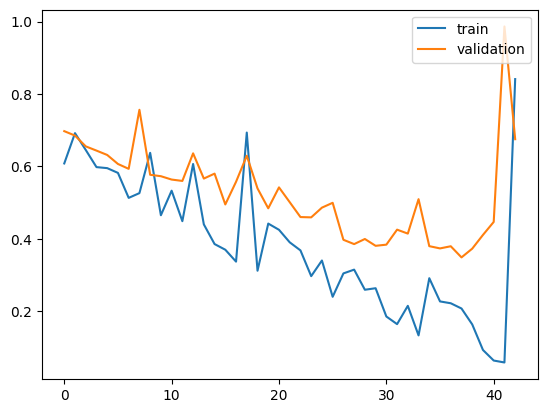

In [18]:
plot_history(train_losses, val_losses)

### Modelo preentrenado

#### Sin Data Augmentation

In [19]:
# Cargamos un modelo preentrenado con el nuevo parámetro 'weights'
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_no_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_no_da.parameters(), lr=0.0001)

pretrained_no_da, train_losses, val_losses = train_model(pretrained_no_da,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_no_DA_ship",
                                                            epochs=99,
                                                            ES_patience=5)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 155MB/s]


Device: cuda:0
Epoch [1/99], train loss: 0.5765, val loss: 0.6460, time: 0.38s
Epoch [2/99], train loss: 0.5052, val loss: 0.5314, time: 0.37s
Epoch [3/99], train loss: 0.4817, val loss: 0.4736, time: 0.37s
Epoch [4/99], train loss: 0.3881, val loss: 0.3930, time: 0.37s
Epoch [5/99], train loss: 0.3133, val loss: 0.3044, time: 0.37s
Epoch [6/99], train loss: 0.2861, val loss: 0.2275, time: 0.37s
Epoch [7/99], train loss: 0.1805, val loss: 0.1724, time: 0.37s
Epoch [8/99], train loss: 0.1409, val loss: 0.1177, time: 0.38s
Epoch [9/99], train loss: 0.0944, val loss: 0.0823, time: 0.37s
Epoch [10/99], train loss: 0.0492, val loss: 0.0667, time: 0.37s
Epoch [11/99], train loss: 0.0338, val loss: 0.0527, time: 0.37s
Epoch [12/99], train loss: 0.0150, val loss: 0.0519, time: 0.37s
Epoch [13/99], train loss: 0.0093, val loss: 0.0535, time: 0.37s
Epoch [14/99], train loss: 0.0054, val loss: 0.0469, time: 0.38s
Epoch [15/99], train loss: 0.0031, val loss: 0.0570, time: 0.37s
Epoch [16/99], trai

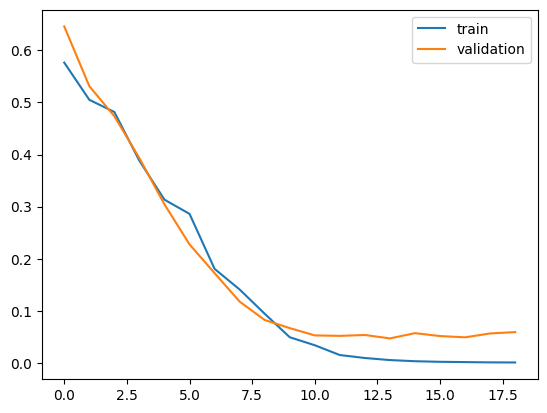

In [20]:
plot_history(train_losses, val_losses)

#### Con Data Augmentation

In [21]:
pretrained_model = squeezenet1_0(weights=weights)

# Definimos el modelo
pretrained_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_da.parameters(), lr=0.0001)

pretrained_da, train_losses, val_losses = train_model(pretrained_da,
                                                            train_loader=aug_train_loader,
                                                            val_loader=aug_val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_DA_ship",
                                                            epochs=99,
                                                            ES_patience=5)

Device: cuda:0
Epoch [1/99], train loss: 0.4548, val loss: 0.3965, time: 0.38s
Epoch [2/99], train loss: 0.3113, val loss: 0.2540, time: 0.37s
Epoch [3/99], train loss: 0.1979, val loss: 0.2068, time: 0.37s
Epoch [4/99], train loss: 0.1275, val loss: 0.1607, time: 0.37s
Epoch [5/99], train loss: 0.0785, val loss: 0.1340, time: 0.37s
Epoch [6/99], train loss: 0.0377, val loss: 0.1236, time: 0.37s
Epoch [7/99], train loss: 0.0243, val loss: 0.1105, time: 0.37s
Epoch [8/99], train loss: 0.0105, val loss: 0.1208, time: 0.37s
Epoch [9/99], train loss: 0.0077, val loss: 0.1376, time: 0.37s
Epoch [10/99], train loss: 0.0042, val loss: 0.1249, time: 0.38s
Epoch [11/99], train loss: 0.0027, val loss: 0.1485, time: 0.38s
Epoch [12/99], train loss: 0.0017, val loss: 0.1581, time: 0.37s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 7 con una pérdida de validación de 0.1105


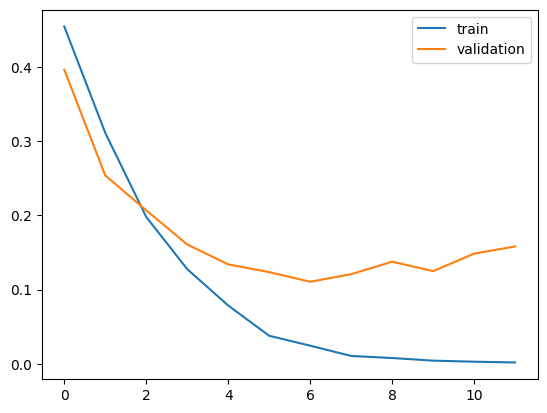

In [22]:
plot_history(train_losses, val_losses)

### Resultados

Device: cuda:0
Métricas:
test accuracy: 81.36 %
test precision: 83.33 %
test recall: 85.71 %
test f1: 84.51 %

Matriz de confusión:


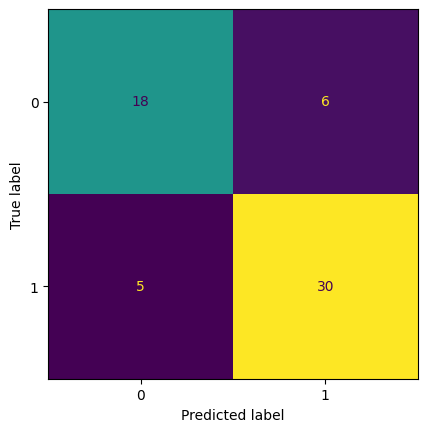


Curva ROC:


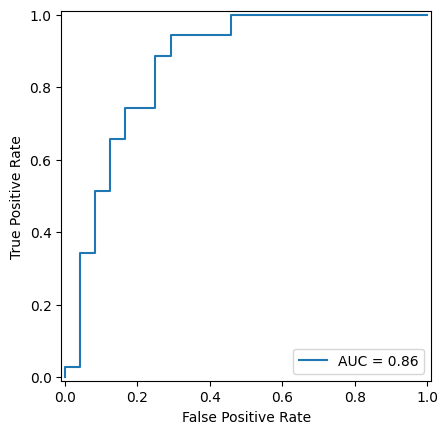

In [23]:
test_model(mymodel_no_da, test_loader);

Device: cuda:0
Métricas:
test accuracy: 83.05 %
test precision: 79.07 %
test recall: 97.14 %
test f1: 87.18 %

Matriz de confusión:


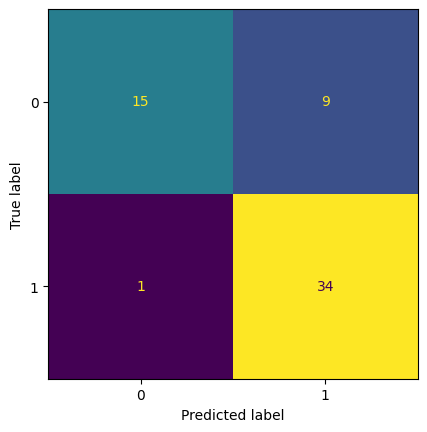


Curva ROC:


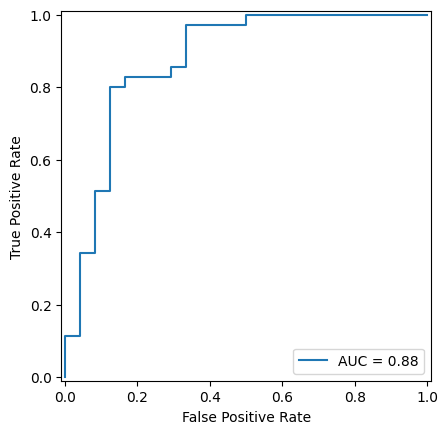

In [24]:
test_model(mymodel_da, test_loader);

Device: cuda:0
Métricas:
test accuracy: 89.83 %
test precision: 89.19 %
test recall: 94.29 %
test f1: 91.67 %

Matriz de confusión:


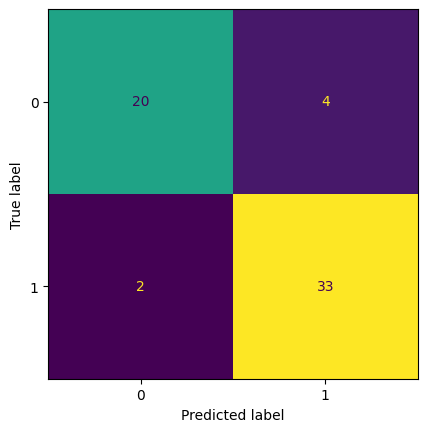


Curva ROC:


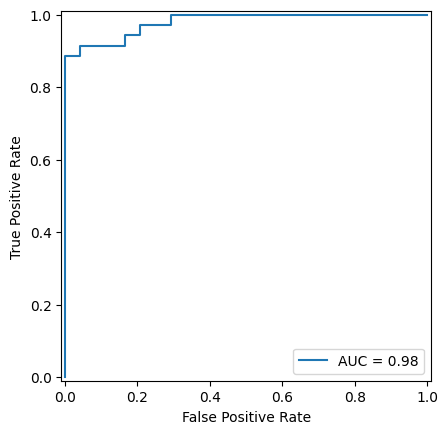

In [25]:
test_model(pretrained_no_da, test_loader);

Device: cuda:0
Métricas:
test accuracy: 93.22 %
test precision: 89.74 %
test recall: 100.00 %
test f1: 94.59 %

Matriz de confusión:


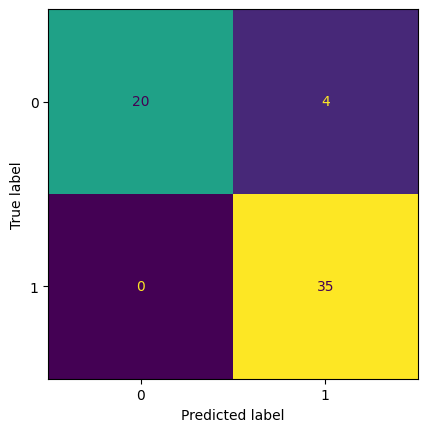


Curva ROC:


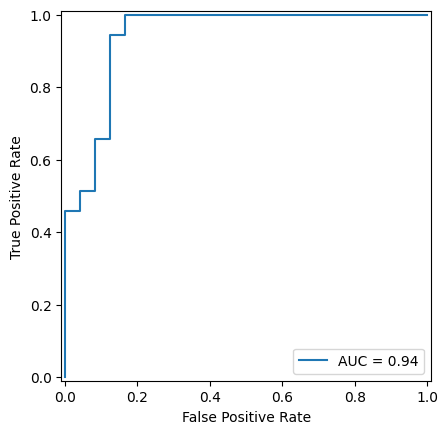

In [26]:
test_model(pretrained_da, test_loader);

## **Tarea 4 (opcional)**:  Clasificación Docked/Undocked

### Creación de dataset y dataloaders

In [27]:
dir = "ship_dataset"
label_csv_filename = "docked.csv"

docked_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
augmented_docked_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=data_augmentation_transforms)
print("Tamaño del dataset completo:", len(docked_dataset))

Imágenes en el dataset: 184
Imágenes en el dataset: 184
Tamaño del dataset completo: 184


1: Atracado, 0: No atracado


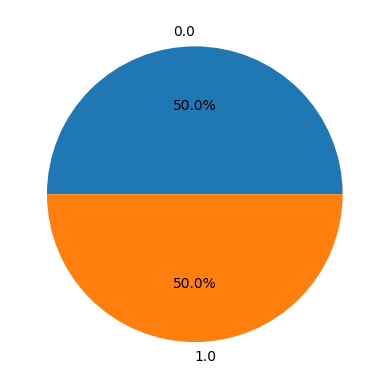

In [28]:
print("1: Atracado, 0: No atracado")
docked_dataset.plot_class_distribution()

In [29]:
# creamos los índices
train_indices, test_indices = train_test_split(list(range(len(docked_dataset))), test_size=0.2, random_state=seed)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=seed)

# cogemos los subsets
train_dataset = data.Subset(docked_dataset, train_indices)
val_dataset = data.Subset(docked_dataset, val_indices)
test_dataset = data.Subset(docked_dataset, test_indices)

aug_train_dataset = data.Subset(augmented_docked_dataset, train_indices)
aug_val_dataset = data.Subset(augmented_docked_dataset, val_indices)

# creamos los dataloaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

aug_train_loader = data.DataLoader(aug_train_dataset, batch_size=batch_size)
aug_val_loader = data.DataLoader(aug_val_dataset, batch_size=batch_size)

### Modelo desde cero
#### Sin Data Augmentation

Device: cuda:0
Epoch [1/99], train loss: 1.1244, val loss: 0.6956, time: 0.32s
Epoch [2/99], train loss: 0.6927, val loss: 0.6947, time: 0.23s
Epoch [3/99], train loss: 0.6916, val loss: 0.6936, time: 0.24s
Epoch [4/99], train loss: 0.6895, val loss: 0.6921, time: 0.23s
Epoch [5/99], train loss: 0.6814, val loss: 0.6901, time: 0.23s
Epoch [6/99], train loss: 0.6780, val loss: 0.6963, time: 0.23s
Epoch [7/99], train loss: 0.6553, val loss: 0.6821, time: 0.23s
Epoch [8/99], train loss: 0.6316, val loss: 0.7103, time: 0.23s
Epoch [9/99], train loss: 0.7301, val loss: 0.7101, time: 0.23s
Epoch [10/99], train loss: 0.6798, val loss: 0.6986, time: 0.23s
Epoch [11/99], train loss: 0.6515, val loss: 0.6723, time: 0.23s
Epoch [12/99], train loss: 0.6254, val loss: 0.6665, time: 0.23s
Epoch [13/99], train loss: 0.6225, val loss: 0.6780, time: 0.23s
Epoch [14/99], train loss: 0.6145, val loss: 0.6893, time: 0.23s
Epoch [15/99], train loss: 0.5970, val loss: 0.7497, time: 0.23s
Epoch [16/99], trai

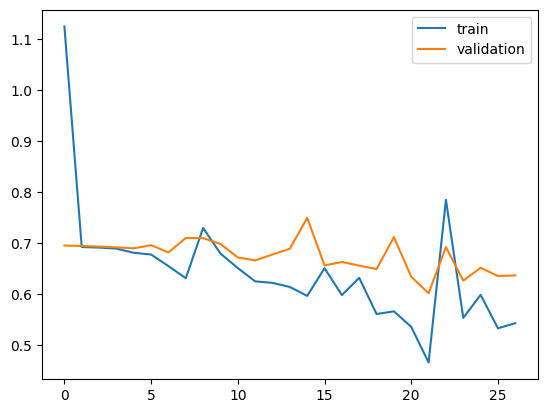

In [30]:
mymodel_no_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_no_da.parameters(), lr=0.001)

mymodel_no_da, train_losses, val_losses = train_model(mymodel_no_da,
                                                train_loader=train_loader,
                                                val_loader=val_loader,
                                                loss_fn=criterion,
                                                optim=optimizer,
                                                device=device,
                                                model_name="npt_no_DA_docked",
                                                epochs=99,
                                                ES_patience=5)
plot_history(train_losses, val_losses)

#### Con Data Augmentation

Device: cuda:0
Epoch [1/99], train loss: 1.2902, val loss: 0.6929, time: 0.23s
Epoch [2/99], train loss: 0.6937, val loss: 0.6934, time: 0.24s
Epoch [3/99], train loss: 0.6929, val loss: 0.6933, time: 0.23s
Epoch [4/99], train loss: 0.6913, val loss: 0.6934, time: 0.24s
Epoch [5/99], train loss: 0.6867, val loss: 0.6931, time: 0.23s
Epoch [6/99], train loss: 0.6709, val loss: 0.6936, time: 0.23s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 1 con una pérdida de validación de 0.6929


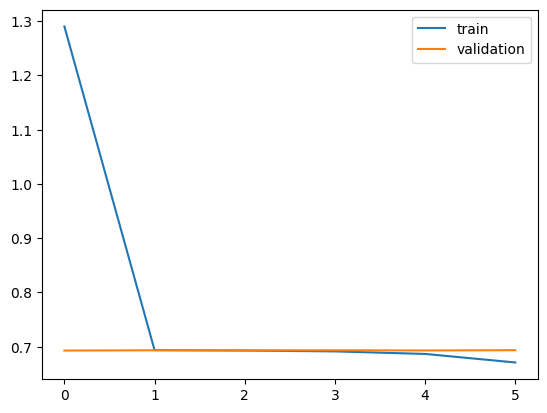

In [31]:
mymodel_da = nn.Sequential(
    squeezenet1_0().features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mymodel_da.parameters(), lr=0.001)

mymodel_da, train_losses, val_losses = train_model(mymodel_da,
                                                    train_loader=aug_train_loader,
                                                    val_loader=aug_val_loader,
                                                    loss_fn=criterion,
                                                    optim=optimizer,
                                                    device=device,
                                                    model_name="npt_DA_docked",
                                                    epochs=99,
                                                    ES_patience=5)
plot_history(train_losses, val_losses)

### Modelo preentrenado
#### Sin Data Augmentation

Device: cuda:0
Epoch [1/99], train loss: 0.7183, val loss: 0.7476, time: 0.29s
Epoch [2/99], train loss: 0.6205, val loss: 0.6423, time: 0.24s
Epoch [3/99], train loss: 0.5640, val loss: 0.5983, time: 0.24s
Epoch [4/99], train loss: 0.5120, val loss: 0.5744, time: 0.23s
Epoch [5/99], train loss: 0.4656, val loss: 0.5537, time: 0.23s
Epoch [6/99], train loss: 0.4100, val loss: 0.5211, time: 0.24s
Epoch [7/99], train loss: 0.3558, val loss: 0.5031, time: 0.24s
Epoch [8/99], train loss: 0.3062, val loss: 0.4920, time: 0.24s
Epoch [9/99], train loss: 0.2495, val loss: 0.4830, time: 0.23s
Epoch [10/99], train loss: 0.2087, val loss: 0.4841, time: 0.24s
Epoch [11/99], train loss: 0.1655, val loss: 0.4925, time: 0.24s
Epoch [12/99], train loss: 0.1389, val loss: 0.5115, time: 0.24s
Epoch [13/99], train loss: 0.1215, val loss: 0.5272, time: 0.24s
Epoch [14/99], train loss: 0.1197, val loss: 0.6374, time: 0.24s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 9 c

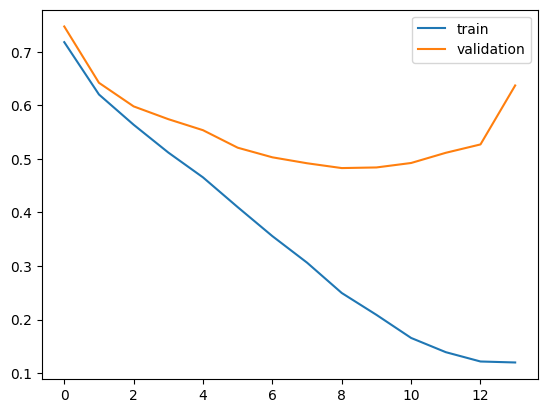

In [32]:
pretrained_model = squeezenet1_0(weights=weights)

pretrained_no_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_no_da.parameters(), lr=0.0001)

pretrained_no_da, train_losses, val_losses = train_model(pretrained_no_da,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_no_DA_docked",
                                                            epochs=99,
                                                            ES_patience=5)
plot_history(train_losses, val_losses)

#### Con Data Augmentation

Device: cuda:0
Epoch [1/99], train loss: 0.6675, val loss: 0.6235, time: 0.23s
Epoch [2/99], train loss: 0.5663, val loss: 0.5826, time: 0.23s
Epoch [3/99], train loss: 0.4627, val loss: 0.5619, time: 0.23s
Epoch [4/99], train loss: 0.3912, val loss: 0.5331, time: 0.24s
Epoch [5/99], train loss: 0.3168, val loss: 0.5522, time: 0.23s
Epoch [6/99], train loss: 0.2653, val loss: 0.5176, time: 0.24s
Epoch [7/99], train loss: 0.2211, val loss: 0.5464, time: 0.24s
Epoch [8/99], train loss: 0.1799, val loss: 0.5331, time: 0.24s
Epoch [9/99], train loss: 0.1451, val loss: 0.5816, time: 0.24s
Epoch [10/99], train loss: 0.1128, val loss: 0.5900, time: 0.23s
Epoch [11/99], train loss: 0.0859, val loss: 0.7089, time: 0.24s
Parando el entrenamiento de forma temprana...
El mejor modelo era el de la epoch 6 con una pérdida de validación de 0.5176


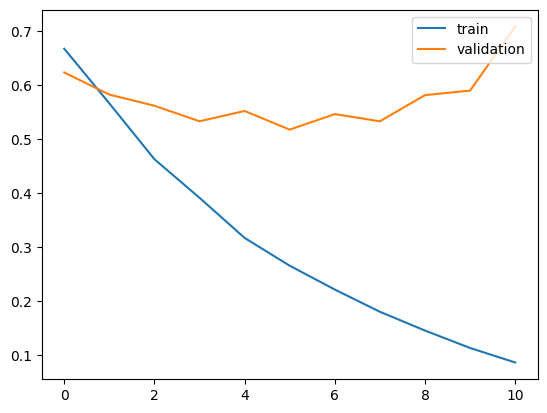

In [33]:
pretrained_model = squeezenet1_0(weights=weights)

pretrained_da = nn.Sequential(
    pretrained_model.features,
    Tail().model
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_da.parameters(), lr=0.0001)

pretrained_da, train_losses, val_losses = train_model(pretrained_da,
                                                            train_loader=aug_train_loader,
                                                            val_loader=aug_val_loader,
                                                            loss_fn=criterion,
                                                            optim=optimizer,
                                                            device=device,
                                                            model_name="pt_DA_docked",
                                                            epochs=99,
                                                            ES_patience=5)
plot_history(train_losses, val_losses)

### Resultados

Device: cuda:0
Métricas:
test accuracy: 48.65 %
test precision: 50.00 %
test recall: 68.42 %
test f1: 57.78 %

Matriz de confusión:


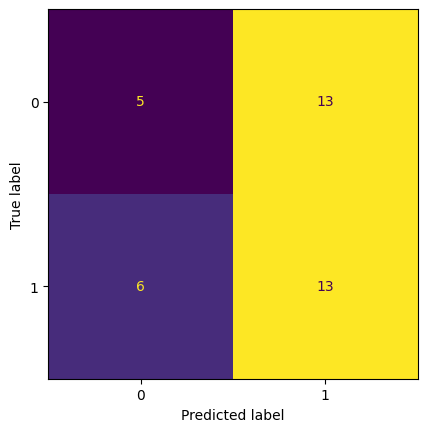


Curva ROC:


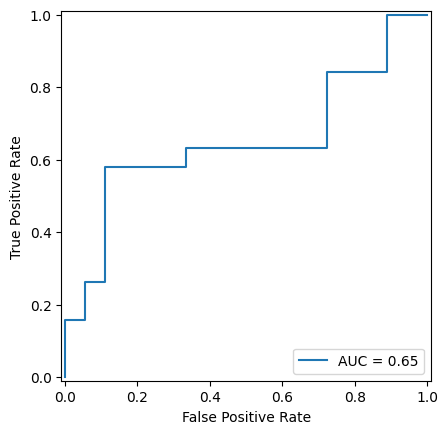

In [34]:
test_model(mymodel_no_da, test_loader);

Device: cuda:0
Métricas:
test accuracy: 51.35 %
test precision: 51.35 %
test recall: 100.00 %
test f1: 67.86 %

Matriz de confusión:


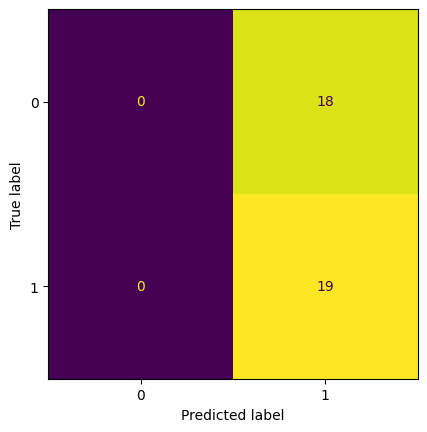


Curva ROC:


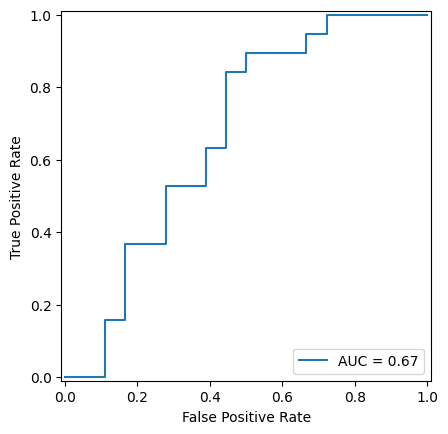

In [35]:
test_model(mymodel_da, test_loader);

Device: cuda:0
Métricas:
test accuracy: 81.08 %
test precision: 77.27 %
test recall: 89.47 %
test f1: 82.93 %

Matriz de confusión:


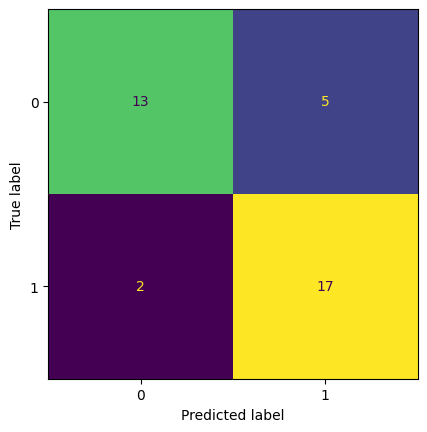


Curva ROC:


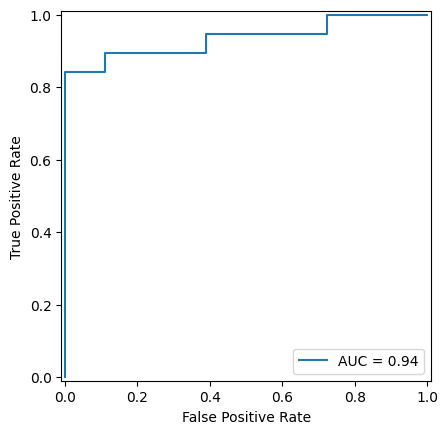

In [36]:
test_model(pretrained_no_da, test_loader);

Device: cuda:0
Métricas:
test accuracy: 75.68 %
test precision: 70.83 %
test recall: 89.47 %
test f1: 79.07 %

Matriz de confusión:


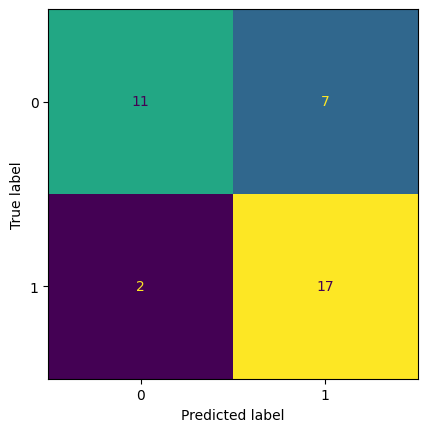


Curva ROC:


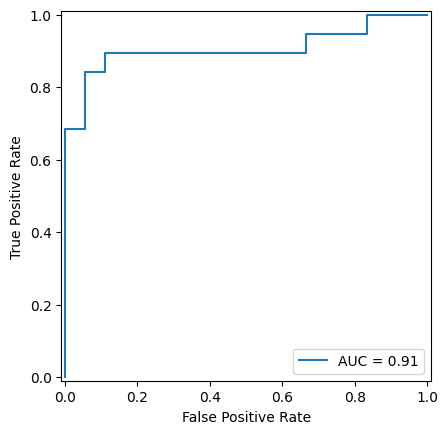

In [37]:
test_model(pretrained_da, test_loader);